In [ ]:
from pandas.conftest import index
%load_ext autoreload

In [1]:
# %autoreload
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
from typing import Dict
from pathlib import Path
from shapely.ops import linemerge
from shapely import geometry
import overpy
from geoalchemy2 import Geometry

from roadgraphtool.config import parse_config_file
import roadgraphtool.db
from roadgraphtool.db import db


In [2]:
config_path = Path(r"C:\Google Drive AIC\My Drive\AIC Experiment Data\RGT\Chyse/config.yaml")

In [3]:
config = parse_config_file(config_path)
roadgraphtool.db.init_db(config)
roadgraphtool.db.db.start_or_restart_ssh_connection_if_needed()

In [65]:
graph = ox.graph_from_place("Chyše", network_type='drive', simplify=False, retain_all=True, truncate_by_edge=True)
graph

In [66]:
nodes_df = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df.x, nodes_df.y), crs="EPSG:4326")
nodes_gdf.drop(columns=['x', 'y', 'street_count', 'railway', 'ref'], inplace=True)
nodes_gdf.rename(columns={'geometry': 'geom'}, inplace=True)
nodes_gdf.set_geometry('geom', inplace=True)
nodes_gdf.index.rename('id', inplace=True)
nodes_gdf

,geom
id,
73926336,POINT (13.23583 50.12873)
73928265,POINT (13.25014 50.11015)
73932401,POINT (13.24598 50.10503)
73933148,POINT (13.28257 50.11311)
73935828,POINT (13.26902 50.1071)
...,...
12827469010,POINT (13.25517 50.07186)
12827469284,POINT (13.2447 50.08579)
12827469400,POINT (13.23625 50.09803)


In [51]:
db.geodataframe_to_db_table(nodes_gdf, "nodes", srid=4326)

In [67]:
edges_gdf = ox.graph_to_gdfs(graph, nodes=False)
edges_gdf.reset_index(inplace=True)
edges_gdf['position'] = edges_gdf.groupby('osmid').cumcount()
edges_gdf

,u,v,key,osmid,highway,ref,oneway,reversed,length,maxspeed,name,width,bridge,geometry,position
0,73926336,4960162679,0,630145614,secondary,194,False,False,11.791315,NaN,NaN,NaN,NaN,"LINESTRING (13.23583 50.12873, 13.23573 50.12882)",0
1,73926336,4960162680,0,630145614,secondary,194,False,True,12.337713,NaN,NaN,NaN,NaN,"LINESTRING (13.23583 50.12873, 13.23594 50.12865)",1
2,73928265,3199817070,0,9569510,secondary,194,False,True,10.531002,50,Nádražní,NaN,NaN,"LINESTRING (13.25014 50.11015, 13.25007 50.11007)",0
3,73928265,3199817074,0,28427131,tertiary,1949,False,False,13.016406,50,Podštělská,NaN,NaN,"LINESTRING (13.25014 50.11015, 13.25031 50.11011)",0
4,73928265,3199817080,0,73902009,secondary,194,False,False,26.980746,NaN,NaN,NaN,NaN,"LINESTRING (13.25014 50.11015, 13.25028 50.11038)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,12827469400,312300068,0,454105171,tertiary,20515,False,True,12.263932,NaN,NaN,NaN,NaN,"LINESTRING (13.23625 50.09803, 13.23639 50.09796)",5
1642,13188833018,9783716025,0,324900038,tertiary,2264,False,False,12.902053,NaN,NaN,NaN,NaN,"LINESTRING (13.28965 50.10933, 13.28949 50.10938)",12
1643,13188833018,13188833021,0,324900038,tertiary,2264,False,True,28.900423,NaN,NaN,NaN,NaN,"LINESTRING (13.28965 50.10933, 13.29 50.1092)",13
1644,13188833021,13188833018,0,324900038,tertiary,2264,False,False,28.900423,NaN,NaN,NaN,NaN,"LINESTRING (13.29 50.1092, 13.28965 50.10933)",14


In [68]:
node_ways_list = []
ways_list = []
def process_way(way: gpd.GeoDataFrame):
    last_record = way.iloc[-1]

    # add nodes to nodeways list
    for from_node_id, to_node_id, position in zip(way['u'], way['v'], way['position']):
        node_ways_list.append({
            'node_id': from_node_id,
            'way_id': way.name,
            'position': position
        })
    # add the last point
    node_ways_list.append({
        'node_id': last_record['v'],
        'way_id': way.name,
        'position': last_record['position'] + 1
    })

    # add the way
    geometry = way['geometry'].union_all()
    if geometry.geom_type == 'MultiLineString':
        geometry = linemerge(geometry)
    ways_list.append({
        'id': way.name,
        'geom': geometry,
        'area': 0,
        'from': way.iloc[0]['u'],
        'to': last_record['v'],
        'oneway': last_record['oneway']
    })

    return 0

In [69]:
edges_gdf.groupby('osmid').apply(process_way, include_groups=False)

nodes_ways_df = pd.DataFrame(node_ways_list)
ways_gdf = gpd.GeoDataFrame(ways_list, geometry='geom', crs="EPSG:4326")
nodes_ways_df

,node_id,way_id,position
0,73928265,9569510,0
1,73987660,9569510,1
2,73987660,9569510,2
3,74058155,9569510,3
4,74058155,9569510,4
...,...,...,...
1715,3690826388,1385450800,14
1716,3690840228,1385450800,15
1717,9874604607,1385450800,16
1718,9874604607,1385450800,17


In [71]:
ways_gdf

,id,geom,area,from,to,oneway
0,9569510,"LINESTRING (13.24988 50.10697, 13.24987 50.107...",0,73928265,3199816551,False
1,9571743,"LINESTRING (13.25206 50.10449, 13.25149 50.104...",0,73958338,74022198,False
2,27551708,"LINESTRING (13.2572 50.10359, 13.2556 50.10379...",0,73958338,9783715435,False
3,28425994,"MULTILINESTRING ((13.24306 50.095, 13.24305 50...",0,312300031,4371762495,False
4,28427131,"LINESTRING (13.25223 50.11019, 13.25192 50.110...",0,73928265,312316757,False
...,...,...,...,...,...,...
69,1276051296,"LINESTRING (13.25077 50.105, 13.25097 50.10499...",0,550486726,550486728,False
70,1385450787,"LINESTRING (13.24845 50.1054, 13.24885 50.1054...",0,550486704,550486708,False
71,1385450788,"LINESTRING (13.2481 50.1058, 13.24824 50.10581...",0,550486714,550486714,False
72,1385450789,"LINESTRING (13.24795 50.10578, 13.24799 50.105...",0,550486698,3690826413,False


In [53]:
db.geodataframe_to_db_table(ways_df, "ways")

AttributeError: 'DataFrame' object has no attribute 'active_geometry_name'

In [52]:
db.dataframe_to_db_table(nodes_ways_df, "nodes_ways")

IntegrityError: (psycopg2.errors.ForeignKeyViolation) insert or update on table "nodes_ways" violates foreign key constraint "nodes_ways_ways_id_fk"
DETAIL:  Key (way_id)=(9569510) is not present in table "ways".

[SQL: INSERT INTO nodes_ways (node_id, way_id, position) VALUES (%(node_id__0)s, %(way_id__0)s, %(position__0)s), (%(node_id__1)s, %(way_id__1)s, %(position__1)s), (%(node_id__2)s, %(way_id__2)s, %(position__2)s), (%(node_id__3)s, %(way_id__3)s, %(position ... 55376 characters truncated ... __998)s, %(way_id__998)s, %(position__998)s), (%(node_id__999)s, %(way_id__999)s, %(position__999)s)]
[parameters: {'position__0': 0, 'node_id__0': 73928265, 'way_id__0': 9569510, 'position__1': 1, 'node_id__1': 73987660, 'way_id__1': 9569510, 'position__2': 2, 'node_id__2': 73987660, 'way_id__2': 9569510, 'position__3': 3, 'node_id__3': 74058155, 'way_id__3': 9569510, 'position__4': 4, 'node_id__4': 74058155, 'way_id__4': 9569510, 'position__5': 5, 'node_id__5': 74115212, 'way_id__5': 9569510, 'position__6': 6, 'node_id__6': 74115212, 'way_id__6': 9569510, 'position__7': 7, 'node_id__7': 3199816540, 'way_id__7': 9569510, 'position__8': 8, 'node_id__8': 3199816540, 'way_id__8': 9569510, 'position__9': 9, 'node_id__9': 3199816542, 'way_id__9': 9569510, 'position__10': 10, 'node_id__10': 3199816542, 'way_id__10': 9569510, 'position__11': 11, 'node_id__11': 3199816547, 'way_id__11': 9569510, 'position__12': 12, 'node_id__12': 3199816547, 'way_id__12': 9569510, 'position__13': 13, 'node_id__13': 3199816549, 'way_id__13': 9569510, 'position__14': 14, 'node_id__14': 3199816549, 'way_id__14': 9569510, 'position__15': 15, 'node_id__15': 3199816551, 'way_id__15': 9569510, 'position__16': 16, 'node_id__16': 3199816551 ... 2900 parameters truncated ... 'node_id__983': 11096466384, 'way_id__983': 261072132, 'position__984': 45, 'node_id__984': 11096466385, 'way_id__984': 261072132, 'position__985': 46, 'node_id__985': 11096466385, 'way_id__985': 261072132, 'position__986': 47, 'node_id__986': 11096466386, 'way_id__986': 261072132, 'position__987': 48, 'node_id__987': 11096466386, 'way_id__987': 261072132, 'position__988': 49, 'node_id__988': 11096466387, 'way_id__988': 261072132, 'position__989': 50, 'node_id__989': 11096466387, 'way_id__989': 261072132, 'position__990': 51, 'node_id__990': 11096466388, 'way_id__990': 261072132, 'position__991': 52, 'node_id__991': 11096466388, 'way_id__991': 261072132, 'position__992': 53, 'node_id__992': 11096466389, 'way_id__992': 261072132, 'position__993': 54, 'node_id__993': 11096466389, 'way_id__993': 261072132, 'position__994': 55, 'node_id__994': 11096466390, 'way_id__994': 261072132, 'position__995': 56, 'node_id__995': 11096466390, 'way_id__995': 261072132, 'position__996': 57, 'node_id__996': 11096466391, 'way_id__996': 261072132, 'position__997': 58, 'node_id__997': 11096466391, 'way_id__997': 261072132, 'position__998': 59, 'node_id__998': 11096466392, 'way_id__998': 261072132, 'position__999': 60, 'node_id__999': 11096466392, 'way_id__999': 261072132}]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [40]:
edges_gdf[edges_gdf['osmid'] == 9569510]

,u,v,key,osmid,highway,ref,oneway,reversed,length,maxspeed,name,width,bridge,geometry,position
2,73928265,3199817070,0,9569510,secondary,194,False,True,10.531002,50,Nádražní,NaN,NaN,"LINESTRING (13.25014 50.11015, 13.25007 50.11007)",0
39,73987660,3199817063,0,9569510,secondary,194,False,False,48.376711,50,Nádražní,NaN,NaN,"LINESTRING (13.24943 50.10934, 13.24973 50.10973)",1
40,73987660,3690859488,0,9569510,secondary,194,False,True,30.019577,50,Nádražní,NaN,NaN,"LINESTRING (13.24943 50.10934, 13.24927 50.10909)",2
88,74058155,3199816551,0,9569510,secondary,194,False,False,13.344418,50,Nádražní,NaN,NaN,"LINESTRING (13.24908 50.10851, 13.24908 50.10863)",3
89,74058155,3199816549,0,9569510,secondary,194,False,True,10.406556,50,Nádražní,NaN,NaN,"LINESTRING (13.24908 50.10851, 13.2491 50.10842)",4
135,74115212,3199816540,0,9569510,secondary,194,False,False,31.708006,50,Nádražní,NaN,NaN,"LINESTRING (13.24987 50.10701, 13.24976 50.10729)",5
136,74115212,3690840228,0,9569510,secondary,194,False,True,5.114457,50,Nádražní,NaN,NaN,"LINESTRING (13.24987 50.10701, 13.24988 50.10697)",6
654,3199816540,3199816542,0,9569510,secondary,194,False,False,32.064839,50,Nádražní,NaN,NaN,"LINESTRING (13.24976 50.10729, 13.2496 50.10756)",7
655,3199816540,74115212,0,9569510,secondary,194,False,True,31.708006,50,Nádražní,NaN,NaN,"LINESTRING (13.24976 50.10729, 13.24987 50.10701)",8
656,3199816542,9874604533,0,9569510,secondary,194,False,False,33.522779,50,Nádražní,NaN,NaN,"LINESTRING (13.2496 50.10756, 13.24941 50.10784)",9


In [75]:
features = ox.features_from_place('Chyše', tags={'highway': True})
features

geometry  \
element id                                                               
node    9783715299                           POINT (13.25052 50.09511)   
        11480767758                          POINT (13.23629 50.12853)   
        12827468704                          POINT (13.27755 50.09706)   
        12827468714                          POINT (13.25474 50.08787)   
way     9569510      LINESTRING (13.24988 50.10697, 13.24987 50.107...   
...                                                                ...   
        1434873062   LINESTRING (13.29032 50.10959, 13.29038 50.109...   
        1434873063   LINESTRING (13.29028 50.10953, 13.29033 50.109...   
        1434873064   LINESTRING (13.29042 50.10961, 13.29038 50.10963)   
        1434873065   LINESTRING (13.29047 50.10972, 13.29019 50.109...   
        1434873067   LINESTRING (13.29047 50.10992, 13.29026 50.109...   

                                    highway  bus                    name  \
element id                                                                 
node    9783715299           turning_circle  NaN                     NaN   
        11480767758                bus_stop  yes  Nová Teplice, rozcestí   
        12827468704  emergency_access_point  NaN                     NaN   
        12827468714  emergency_access_point  NaN                     NaN   
way     9569510                   secondary  NaN                Nádražní   
...                                     ...  ...                     ...   
        1434873062                  footway  NaN                     NaN   
        1434873063                  footway  NaN                     NaN   
        1434873064                  footway  NaN                     NaN   
        1434873065                  footway  NaN                     NaN   
        1434873067                  footway  NaN                     NaN   

                                                 note  \
element id                                              
node    9783715299                                NaN   
        11480767758  v CIS JŘ je chyba v názvu (Nové)   
        12827468704                               NaN   
        12827468714                               NaN   
way     9569510                                   NaN   
...                                               ...   
        1434873062                                NaN   
        1434873063                                NaN   
        1434873064                                NaN   
        1434873065                                NaN   
        1434873067                                NaN   

                                  official_name public_transport ref:CIS_JR  \
element id                                                                    
node    9783715299                          NaN              NaN        NaN   
        11480767758  Chyše, Nové Teplice, rozc.         platform      12277   
        12827468704                         NaN              NaN        NaN   
        12827468714                         NaN              NaN        NaN   
way     9569510                             NaN              NaN        NaN   
...                                         ...              ...        ...   
        1434873062                          NaN              NaN        NaN   
        1434873063                          NaN              NaN        NaN   
        1434873064                          NaN              NaN        NaN   
        1434873065                          NaN              NaN        NaN   
        1434873067                          NaN              NaN        NaN   

                    emergency_telephone_code       operator  ... service  \
element id                                                   ...           
node    9783715299                       NaN            NaN  ...     NaN   
        11480767758                      NaN            NaN  ...     NaN   
        12827468704                 

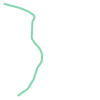

In [79]:
features.loc[('way',28425994)]['geometry']

In [4]:
area = "Chyše"
filter = """
highway~"(motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|unclassified|unclassified_link|residential|residential_link|living_street)"
"""
query = f"""
area[name="{area}"];
(
    (way(area)[{filter}];)->.edges;.edges>->.nodes;
);
out;
"""
api = overpy.Overpass()
result = api.query(query)

In [10]:
node_list = [{'id': node.id, 'lat': node.lat, 'lon': node.lon} for node in result.nodes]
node_df = pd.DataFrame(node_list)
node_gdf = gpd.GeoDataFrame(node_df, geometry=gpd.points_from_xy(node_df.lon, node_df.lat), crs="EPSG:4326")
node_gdf.drop(columns=['lon', 'lat'], inplace=True)
node_gdf.rename(columns={'geometry': 'geom'}, inplace=True)
node_gdf.set_geometry('geom', inplace=True)
node_gdf.set_index('id', inplace=True)
node_gdf

,geom
id,
73926336,POINT (13.23583 50.12873)
73928265,POINT (13.25014 50.11015)
73932401,POINT (13.24598 50.10503)
73933148,POINT (13.28257 50.11311)
73935828,POINT (13.26902 50.1071)
...,...
12827469459,POINT (13.24251 50.09046)
12827469460,POINT (13.24248 50.09061)
12827469461,POINT (13.24253 50.09153)


In [11]:
db.geodataframe_to_db_table(node_gdf, "nodes", srid=4326)

In [5]:
nodes_ways_list = []
ways_list = []

for way in result.ways:

    # add nodes to nodeways list
    for position, node_id in enumerate(way.nodes):
        nodes_ways_list.append({
            'node_id': node_id.id,
            'way_id': way.id,
            'position': position
        })

    # add the way
    ways_list.append({
        'id': way.id,
        'geom': geometry.LineString([node.lon, node.lat] for node in way.nodes),
        'area': 0,
        'from': way.nodes[0].id,
        'to': way.nodes[-1].id,
        'oneway': False
    })

In [6]:
ways_gdf = gpd.GeoDataFrame(ways_list, geometry='geom', crs="EPSG:4326")
ways_gdf.set_index('id', inplace=True)
ways_gdf

,geom,area,from,to,oneway
id,,,,,
9569510,"LINESTRING (13.24988 50.10697, 13.24987 50.107...",0,3690840228,73928265,False
9571743,"LINESTRING (13.25064 50.10488, 13.25095 50.104...",0,74085736,73958338,False
27551708,"LINESTRING (13.25206 50.10449, 13.25221 50.104...",0,73958338,302449977,False
28425994,"LINESTRING (13.23951 50.07782, 13.23954 50.077...",0,4967286799,312300068,False
28427131,"LINESTRING (13.25014 50.11015, 13.25031 50.110...",0,73928265,312316764,False
...,...,...,...,...,...
1276051296,"LINESTRING (13.25077 50.105, 13.25097 50.10499...",0,550486726,550486731,False
1385450787,"LINESTRING (13.24845 50.1054, 13.24885 50.1054...",0,550486704,550486706,False
1385450788,"LINESTRING (13.24834 50.10581, 13.24824 50.105...",0,550486714,3690826415,False


In [15]:
db.geodataframe_to_db_table(ways_gdf, "ways")

In [17]:
nodes_ways_df = pd.DataFrame(nodes_ways_list)
db.dataframe_to_db_table(nodes_ways_df, "nodes_ways", stored_index=False)